In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pymc3 as pm
import langevin
import langevin_cached_model as lcm
import lmfit as lm
from lmfit.models import ExponentialModel
from scipy.stats import pearsonr
from scipy.optimize import minimize_scalar

SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

SEED = 35010732 # from random.org
np.random.seed(SEED)

print(plt.style.available)
plt.style.use('seaborn-white')

['seaborn-dark', 'seaborn-darkgrid', 'seaborn-ticks', 'fivethirtyeight', 'seaborn-whitegrid', 'classic', '_classic_test', 'fast', 'seaborn-talk', 'seaborn-dark-palette', 'seaborn-bright', 'seaborn-pastel', 'grayscale', 'seaborn-notebook', 'ggplot', 'seaborn-colorblind', 'seaborn-muted', 'seaborn', 'Solarize_Light2', 'seaborn-paper', 'bmh', 'tableau-colorblind10', 'seaborn-white', 'dark_background', 'seaborn-poster', 'seaborn-deep']


In [2]:
# function to calculate A and B from the dataset
def OUanalytic1(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/2/A**2
    Btmp = (N-1)*(1+B**2)/(1-B**2)**2
    tmp = (2+6*B**2)*(data1sq+dataNsq) + (4+12*B**2)*datasq - (12*B+4*B**3)*datacorr
    P2B = Btmp - tmp/A/2/(1-B**2)**3
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult1(data,deltat):
    A, dA, B ,dB = OUanalytic1(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [3]:
# function to calculate A and B from the dataset
def OUanalytic2(data):
    N = data.size
    data1sq = data[0]**2
    dataNsq = data[-1]**2
    datasq = np.sum(data[1:-1]**2)
    datacorr = np.sum(data[0:-1]*data[1:])
    coef = [(N-1)*datasq,
       (2.0-N)*datacorr,
       -data1sq-(N+1)*datasq-dataNsq,
       N*datacorr]
    B=np.roots(coef)[-1]
    Q=(data1sq+dataNsq)/(1-B**2)
    Q=Q+datasq*(1+B**2)/(1-B**2)
    Q=Q-datacorr*2*B/(1-B**2)
    A = Q/N
    P2A = -N/A**2/2
    Btmp = B**2*(1+2*N)
    tmp = (1+Btmp)*(data1sq+dataNsq) + (2*Btmp + N + 1 -B**4*(N-1))*datasq - 2*B*(1+B**2+2*N)*datacorr
    P2B = -tmp/((1-B**2)**2*(data1sq+dataNsq + (1+B**2)*datasq - 2*B*datacorr))
    PAB = (N-1)*B/A/(1-B**2)
    dA = np.sqrt(-P2B/(P2A*P2B-PAB**2))
    dB = np.sqrt(-P2A/(P2A*P2B-PAB**2))
    return A,dA,B,dB

def OUresult2(data,deltat):
    A, dA, B ,dB = OUanalytic2(data)
    tau = -deltat/np.log(B)
    dtau = deltat*dB/B/np.log(B)**2
    return A,dA,tau,dtau

In [4]:
A,D = 1.0,1.0
delta_t_list=np.linspace(0.01,2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))

In [5]:
# let us first calculate the standard deviation for each point of the acf
# all acfs are stored in acf_all for later analysis

result_Bayes_array = None
for delta_t in delta_t_list:
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    
    results = OUresult1(data,delta_t)
    if result_Bayes_array is None:
        result_Bayes_array = results
    else:
        result_Bayes_array = np.vstack((result_Bayes_array, results))

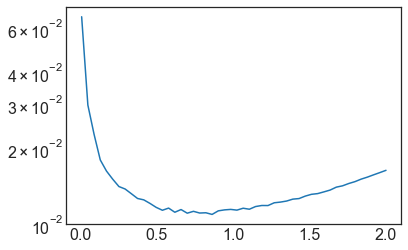

In [6]:
plt.semilogy(delta_t_list,result_Bayes_array.T[3])

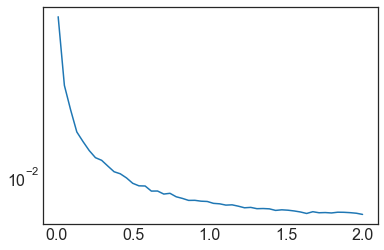

In [7]:
plt.semilogy(delta_t_list,result_Bayes_array.T[1])

In [8]:
A,D = 1.0,1.0
tau_real = A/D
delta_t_list=np.linspace(0.01,2,50)
#M=1000 # number of data sets
N=50000 # length of data set
#print(np.exp(-delta_t*D/A))
pick_delta = 7
print(delta_t_list[pick_delta])
data = langevin.time_series(A=A, D=D, delta_t=delta_t_list[pick_delta], N=N)

0.2942857142857143


In [9]:
# compile model for reuse
sm = lcm.OU_DA()
sm.samples=20000

In [10]:
trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t_list[pick_delta],
                N=50000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:13<00:00, 558.08draws/s]
The acceptance probability does not match the target. It is 0.8800591633844169, but should be close to 0.8. Try to increase the number of tuning steps.


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1c27e6f7b8>,
      dtype=object)

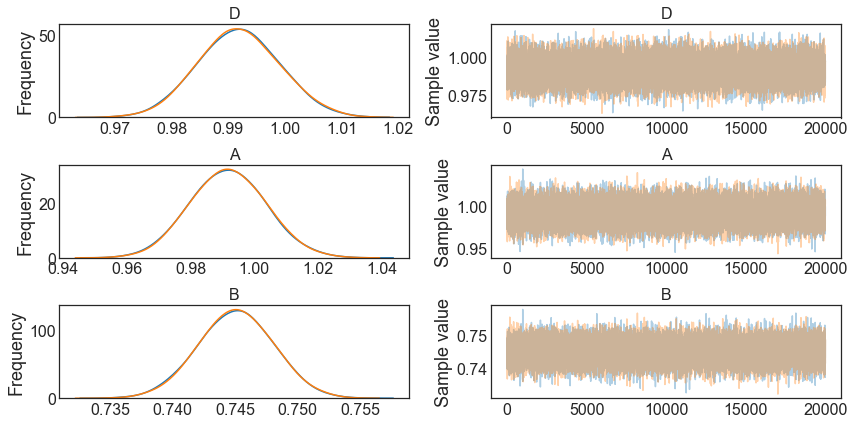

In [11]:
pm.traceplot(trace)

In [12]:
result_array = None
for delta_t in delta_t_list:
    print(delta_t)
    data = langevin.time_series(A=A, D=D, delta_t=delta_t, N=N)
    trace = sm.run(x=data,
                d_bound=5,
                a_bound=5,
                delta_t=delta_t,
                N=50000)
    a_mean = trace['A'].mean()
    d_mean = trace['D'].mean()
    a_std = trace['A'].std()
    d_std = trace['D'].std()
    results = [a_mean,a_std,d_mean,d_std]
    if result_array is None:
        result_array = results
    else:
        result_array = np.vstack((result_array, results))

0.01


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:34<00:00, 435.48draws/s]
The acceptance probability does not match the target. It is 0.8929733682218735, but should be close to 0.8. Try to increase the number of tuning steps.


0.05061224489795919


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:31<00:00, 450.09draws/s]
The acceptance probability does not match the target. It is 0.8799512188444328, but should be close to 0.8. Try to increase the number of tuning steps.


0.09122448979591836


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:29<00:00, 460.34draws/s]


0.13183673469387755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:27<00:00, 467.07draws/s]
The acceptance probability does not match the target. It is 0.8811733939386228, but should be close to 0.8. Try to increase the number of tuning steps.


0.17244897959183675


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 486.55draws/s]
The acceptance probability does not match the target. It is 0.8882480160499661, but should be close to 0.8. Try to increase the number of tuning steps.


0.21306122448979592


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 519.68draws/s]
The acceptance probability does not match the target. It is 0.8897153505620963, but should be close to 0.8. Try to increase the number of tuning steps.


0.2536734693877551


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:18<00:00, 523.51draws/s]
The acceptance probability does not match the target. It is 0.8825931160537941, but should be close to 0.8. Try to increase the number of tuning steps.


0.2942857142857143


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:22<00:00, 499.70draws/s]
The acceptance probability does not match the target. It is 0.8894516590167955, but should be close to 0.8. Try to increase the number of tuning steps.


0.3348979591836735


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:30<00:00, 451.18draws/s]


0.37551020408163266


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:40<00:00, 407.50draws/s]
The acceptance probability does not match the target. It is 0.8933124526401987, but should be close to 0.8. Try to increase the number of tuning steps.


0.41612244897959183


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:49<00:00, 296.26draws/s]
The acceptance probability does not match the target. It is 0.8908542935871129, but should be close to 0.8. Try to increase the number of tuning steps.


0.45673469387755106


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:40<00:00, 408.80draws/s]
The acceptance probability does not match the target. It is 0.89052060994428, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8906620917856292, but should be close to 0.8. Try to increase the number of tuning steps.


0.49734693877551023


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:17<00:00, 528.88draws/s]


0.5379591836734694


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:28<00:00, 189.53draws/s]
The acceptance probability does not match the target. It is 0.8846643023141684, but should be close to 0.8. Try to increase the number of tuning steps.


0.5785714285714286


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:23<00:00, 493.90draws/s]


0.6191836734693877


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:24<00:00, 487.70draws/s]
The acceptance probability does not match the target. It is 0.8918473736248639, but should be close to 0.8. Try to increase the number of tuning steps.


0.659795918367347


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:17<00:00, 529.03draws/s]


0.7004081632653062


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:15<00:00, 542.87draws/s]


0.7410204081632653


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:17<00:00, 530.87draws/s]
The acceptance probability does not match the target. It is 0.8855784139623841, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8795507698430101, but should be close to 0.8. Try to increase the number of tuning steps.


0.7816326530612245


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:17<00:00, 531.60draws/s]
The acceptance probability does not match the target. It is 0.8816006572259133, but should be close to 0.8. Try to increase the number of tuning steps.


0.8222448979591837


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:25<00:00, 478.76draws/s]
The acceptance probability does not match the target. It is 0.8895380041752332, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8952814391315671, but should be close to 0.8. Try to increase the number of tuning steps.


0.8628571428571429


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [57:53<00:00, 11.80draws/s]    


0.9034693877551021


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:30<00:00, 453.89draws/s]


0.9440816326530612


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:34<00:00, 433.18draws/s]


0.9846938775510204


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:38<00:00, 415.36draws/s]


1.0253061224489797


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:47<00:00, 379.75draws/s]
The acceptance probability does not match the target. It is 0.8888834866806852, but should be close to 0.8. Try to increase the number of tuning steps.


1.0659183673469388


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:33<00:00, 436.28draws/s]
The acceptance probability does not match the target. It is 0.8863229779791384, but should be close to 0.8. Try to increase the number of tuning steps.


1.106530612244898


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:06<00:00, 187.50draws/s]


1.1471428571428572


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:40<00:00, 255.49draws/s]


1.1877551020408164


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:54<00:00, 235.48draws/s]
The acceptance probability does not match the target. It is 0.8799359088799048, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8945938569665796, but should be close to 0.8. Try to increase the number of tuning steps.


1.2283673469387755


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:38<00:00, 259.46draws/s]


1.2689795918367348


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:48<00:00, 243.31draws/s]


1.309591836734694


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:35<00:00, 263.59draws/s]
The acceptance probability does not match the target. It is 0.8850560958911415, but should be close to 0.8. Try to increase the number of tuning steps.


1.350204081632653


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:35<00:00, 263.83draws/s]
The acceptance probability does not match the target. It is 0.8818668853300395, but should be close to 0.8. Try to increase the number of tuning steps.


1.3908163265306124


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:38<00:00, 258.43draws/s]
The acceptance probability does not match the target. It is 0.8846326848383473, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8809952599584842, but should be close to 0.8. Try to increase the number of tuning steps.


1.4314285714285715


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:19<00:00, 294.34draws/s]
The acceptance probability does not match the target. It is 0.8822801840690291, but should be close to 0.8. Try to increase the number of tuning steps.


1.4720408163265306


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:14<00:00, 305.73draws/s]


1.51265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:20<00:00, 292.14draws/s]
The acceptance probability does not match the target. It is 0.8832275826316469, but should be close to 0.8. Try to increase the number of tuning steps.


1.553265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:26<00:00, 279.12draws/s]


1.5938775510204082


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:28<00:00, 275.52draws/s]
The acceptance probability does not match the target. It is 0.8844102575612844, but should be close to 0.8. Try to increase the number of tuning steps.


1.6344897959183673


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:44<00:00, 249.11draws/s]
The acceptance probability does not match the target. It is 0.8965908748529312, but should be close to 0.8. Try to increase the number of tuning steps.


1.6751020408163266


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:20<00:00, 174.72draws/s]


1.7157142857142857


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:19<00:00, 294.68draws/s]


1.7563265306122449


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:25<00:00, 282.46draws/s]
The acceptance probability does not match the target. It is 0.8827205584664514, but should be close to 0.8. Try to increase the number of tuning steps.
The acceptance probability does not match the target. It is 0.8822626888156772, but should be close to 0.8. Try to increase the number of tuning steps.


1.7969387755102042


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:23<00:00, 286.51draws/s]


1.8375510204081633


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [02:27<00:00, 278.54draws/s]
The acceptance probability does not match the target. It is 0.8916843447797101, but should be close to 0.8. Try to increase the number of tuning steps.


1.8781632653061224


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:52<00:00, 364.60draws/s]
The acceptance probability does not match the target. It is 0.8880079270513648, but should be close to 0.8. Try to increase the number of tuning steps.


1.9187755102040818


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:26<00:00, 472.20draws/s]


1.9593877551020409


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:15<00:00, 542.63draws/s]


2.0


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [A, D]
Sampling 2 chains: 100%|██████████| 41000/41000 [01:13<00:00, 557.19draws/s]


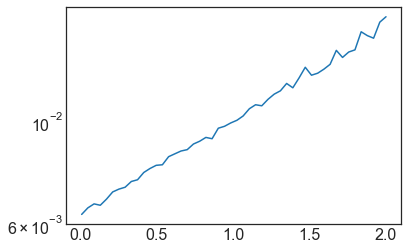

In [13]:
plt.semilogy(delta_t_list,result_array.T[3])

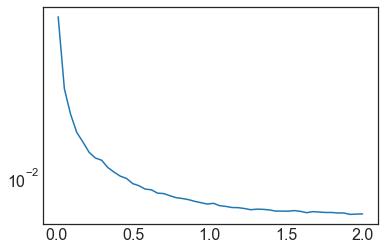

In [14]:
plt.semilogy(delta_t_list,result_array.T[1])

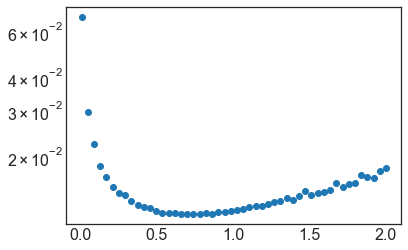

In [15]:
dtau = np.sqrt(result_array.T[1]**2+result_array.T[3]**2)
plt.semilogy(delta_t_list,dtau,"o")

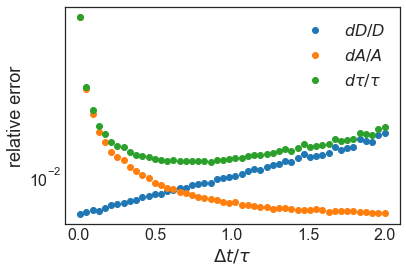

In [16]:
plt.semilogy(delta_t_list,result_array.T[3],"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1],"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau,"o",label=r'$d\tau/\tau$')
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend()

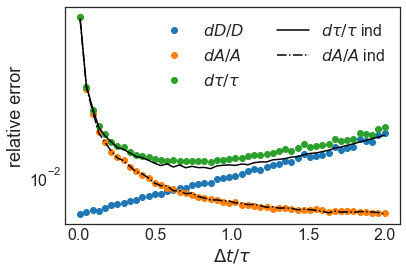

In [18]:
plt.semilogy(delta_t_list,result_array.T[3]/D,"o",label=r"$dD/D$")
plt.semilogy(delta_t_list,result_array.T[1]/A,"o",label=r'$dA/A$')
plt.semilogy(delta_t_list,dtau/tau_real,"o",label=r'$d\tau/\tau$')
plt.semilogy(delta_t_list,result_Bayes_array.T[3]/tau_real,color="k",label=r"$d\tau/\tau$ ind")
plt.semilogy(delta_t_list,result_Bayes_array.T[1]/A,"-.",color="k",label=r"$dA/A$ ind")
plt.xlabel(r'$\Delta t/\tau$')
plt.ylabel("relative error")
plt.legend(ncol=2)
plt.savefig("optimaldt_1_1.png",format='png',dpi=300,bbox_inches='tight',facecolor="white",backgroundcolor="white")